In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import dask
import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
from xhistogram.xarray import histogram

from matplotlib import cm
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

from bbl import *
from osse import *
from canyon_utils import *
from sloped_MITgcm import *
from wmt import *

In [3]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 60.

### Loading output and pre-processing

In [62]:
experiments = ["idealized-plane-1D", "idealized-plane-1D-Pr230", "idealized-plane", "idealized-canyon", "idealized-sill", "canyon"]
data = {}

add_dep = {"idealized-plane": 800.}

for exp in experiments:
    run = "run_spinup"
    #t = 4
    t=-1
    if exp == "canyon":
        run = "run"
        #t = t*2+1
        t=-11
    data_dir = f"../../MITgcm/experiments/rotated_BBTRE_{exp}/{run}/"
    
    #try:
    db = open_mdsdataset(data_dir, iters='all', ignore_unknown_vars=True, prefix=["budgetDiag"], delta_t=delta_t).isel(time=t)
    db, gridb = add_rotated_coords(db, θ)
    
    db = add_hab_coordinates(db, gridb, vert_coord='Zl', gridface='C')
    db['wb'] = db['ADVr_TH']/db["rA"]
    db['wb_hab'] = hab_interp(db['wb'], vert_coord='Zl')
    db['wb_hab_av'] = db['wb_hab'].mean(['XC', 'YC'], skipna=True).compute()
    
    ds = open_mdsdataset(data_dir, iters='all', ignore_unknown_vars=True, prefix=["standardDiag"], delta_t=delta_t).isel(time=t)
    ds, grid = add_rotated_coords(ds, θ)
    # Stratification and masks
    ds['Nsq'] = g*α*(Γ +
            (grid.diff(ds['THETA'].where(ds['hFacC']!=0.), 'Z', boundary='fill')) /
            grid.interp(-ds['drF'], 'Z', boundary='extend')
    ).chunk({'Zl':-1})
    
    ds = add_hab_coordinates(ds, grid, vert_coord='Zl', gridface='C')
    ds['Nsq_hab'] = hab_interp(ds['Nsq'], vert_coord='Zl')
    ds['Nsq_hab_av'] = ds['Nsq_hab'].mean(['XC', 'YC'], skipna=True).compute()
    
    if exp=="idealized-plane":
        ds=ds.assign_coords({'Z':ds["Z"]+add_dep[exp], 'Zl':ds["Zl"]+add_dep[exp], 'Zp1':ds["Zp1"]+add_dep[exp]})
        db=db.assign_coords({'Z':db["Z"]+add_dep[exp], 'Zl':db["Zl"]+add_dep[exp], 'Zp1':db["Zp1"]+add_dep[exp]})
        
        ds=ds.assign_coords({'Zr_W':ds["Zr_W"]+add_dep[exp]})
        db=db.assign_coords({'Zr_W':db["Zr_W"]+add_dep[exp]})
        
    data[exp] = {'ds': ds, 'db': db, 'grid': grid}

/nobackup1b/users/hdrake/bblturb/notebooks/BBTRE_physics_analysis/sloped_MITgcm.py:64: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  da_itp = xr.apply_ufunc(
/nobackup1b/users/hdrake/bblturb/notebooks/BBTRE_physics_analysis/sloped_MITgcm.py:64: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  da_itp = xr.apply_ufunc(
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nobackup1b/users/hdrake/bblturb/notebooks/BBTRE_physics_analysis/sloped_MITgcm.py:64: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  da_itp = xr.apply_ufunc(
/nobackup1b/users/hdrake

40
40
40
640


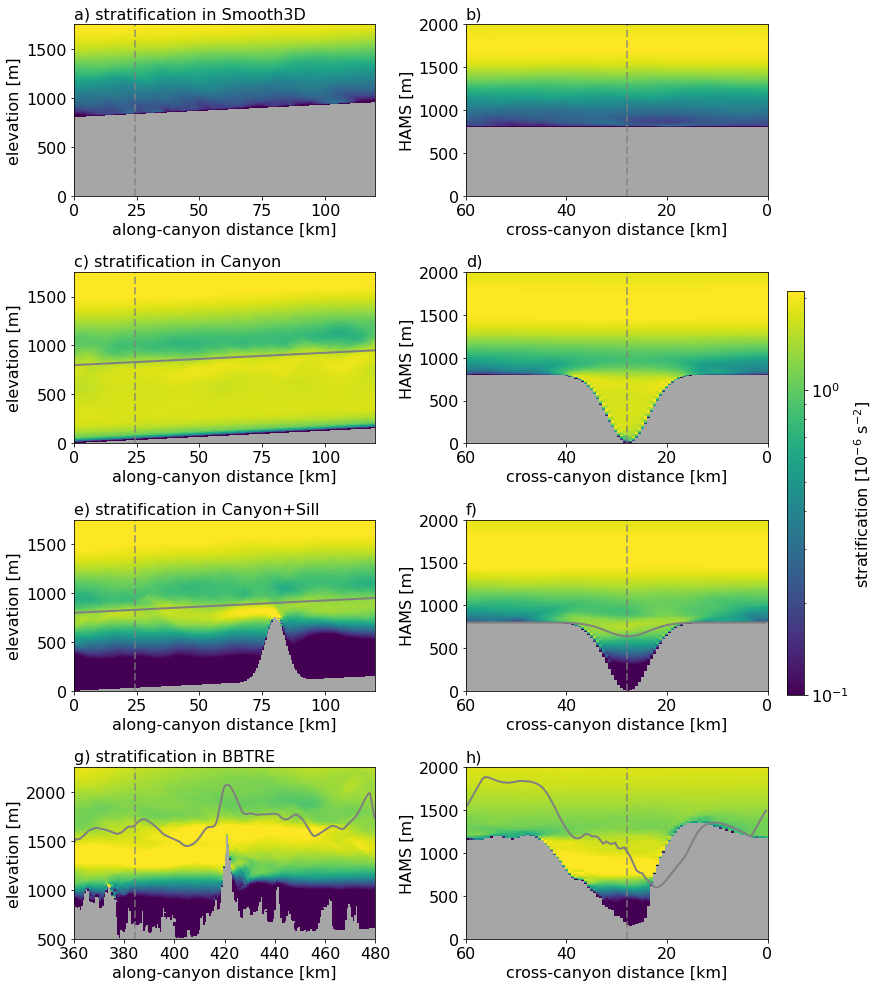

In [110]:
longnames = {
    'canyon': "BBTRE",
    'idealized-sill': "Canyon+Sill",
    'idealized-canyon': "Canyon",
    'idealized-plane': "Smooth3D",
    'idealized-plane-1D': "Planar slope (1D)",
    'idealized-plane-1D-Pr230': r"Planar slope (1D, $\sigma = 230$)"
}

labels=["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]

fig = plt.figure(figsize=(12, 14))
for i, (k,v) in enumerate(data.items()):
    if "1D" in k: continue
        
    ##
    iplot = (i-1)*2-1
    plt.subplot(4,2, iplot, facecolor=nancol)
    nx = v['ds']['XC'].size
    isec = np.mod(640, nx)
    print(isec)
    jsec = 46
    pcol = (1e6*v['ds']['Nsq']).isel(YC=jsec).plot(x="Xr_W", y="Zr_W", cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=1.e-1, vmax=2.1))
    pcol.colorbar.remove()
    
    jidx = np.append(np.arange(0, 10), np.arange(90, 100))
    if k!="idealized-plane":
        (v['ds'].H - v['ds'])['Depthr'].isel(YC=jidx).mean("YC").plot(color=(0.5, 0.5, 0.5), lw=2., alpha=1.)
    plt.axvline(v['ds']['XC'].isel(XC=isec), color=(0.5, 0.5, 0.5), lw=2., linestyle="dashed", alpha=0.65)
    
    plt.ylim(0, 1750)
    plt.title("")
    plt.title(f"{labels[iplot-1]} stratification in {longnames[k]}", loc="left", fontsize=16)
    if k=="canyon":
        plt.xlim(360.e3, 480.e3)
    xt, _ = plt.xticks()
    plt.xticks(xt, np.int64(xt*1e-3))
    if k=="canyon":
        plt.xlim(360.e3, 480.e3)
        plt.ylim(500, 2250)
    else:
        plt.xlim(0, 120.e3)
    plt.xlabel("along-canyon distance [km]")
    plt.ylabel("elevation [m]")
    
    ##
    plt.subplot(4,2,iplot+1, facecolor=nancol)
    pcol = (1e6*v['ds']['Nsq']).isel(XC=isec).plot(y="Zl", cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=1.e-1, vmax=2.1))
    pcol.colorbar.remove()
    
    if k=="canyon":
        (v['ds'].H - v['ds']['Depth']).isel(XC=701).plot(color=(0.5, 0.5, 0.5), lw=2., alpha=1.)
        
    if k=="idealized-sill":
        (v['ds'].H - v['ds']['Depth']).isel(XC=133).plot(color=(0.5, 0.5, 0.5), lw=2., alpha=1.)
    
    plt.axvline(v['ds']['YC'].isel(YC=jsec), color=(0.5, 0.5, 0.5), lw=2., linestyle="dashed", alpha=0.65)
    
    plt.ylim(0, 2000)
    plt.title("", fontsize=16)
    plt.title(labels[iplot], loc="left", fontsize=16)
    xt = np.array([0, 20, 40, 60])
    plt.xticks(xt*1e3, xt)
    plt.xlim(60e3, 0.)
    plt.xlabel("cross-canyon distance [km]")
    plt.ylabel("HAMS [m]")
    
plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.922, 0.3, 0.02, 0.4])
fig.colorbar(pcol, cax=cbar_ax, label=r"stratification [$10^{-6}$ s$^{-2}$]")

plt.savefig("../../figures/BBTRE/stratification_sections.png", bbox_inches="tight", dpi=150.)